Nombre completo: Juan José Montoya Sanchéz

Identificación: 1004998829

⚠️ Al finalizar descargue su notebook en formato .ipynb y envíelo al correo sebastian.duquem@udea.edu.co con el asunto Lab computacional 2 - 1004998829.

# Tranformada de Fourier Cuántica

Utilice las notas de clase, la entrada de Wikipedia [Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform#Circuit_implementation) y el tutorial de Pennylane [Intro to the Quantum Fourier Transform](https://pennylane.ai/qml/demos/tutorial_qft).

In [246]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl

# Configurar matplotlib para usar una fuente que tenga símbolos griegos
mpl.rcParams['font.family'] = 'DejaVu Sans'

plt.style.use('pennylane.drawer.plot')

Inserte en la siguiente celda su fecha de nacimiento en el formato DDMMAAAA para calcular un valor aleatorio de $\theta$

In [273]:
seed = 8092000 # fecha de nacimiento en formato DDMMAAAA 

Y definamos el número de qubits en nuestro circuito

In [274]:
NUM_QUBITS = 8

# lista de divisores de NUM_QUBITS y de ahi tomamos el meximo distinto a si mismo para  posteriormente graficar
divisor = np.max([i for i in range(1, NUM_QUBITS + 1) if (NUM_QUBITS % i == 0 and i != NUM_QUBITS)])

if divisor == 1:
    divisor = NUM_QUBITS // 2  # Si no hay divisores, usar la mitad entera de NUM_QUBITS

divisor 

np.int64(4)

La siguiente función prepara el estado con periodo $\tau \in \mathbb{Z}$

$$|\psi_\tau\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} \exp \left (-2 \pi i\frac{x}{\tau} \right)|x\rangle_n,$$

donde el número de qubits $n$ se define con el argumento `num_qubits`.

In [275]:
def preparar_estado(num_qubits):
  """función cuántica que prepara el estado inicial

  Args:
    num_qubits (int): número de qubits.
  """
  # Define un qubit auxiliar (ancilla) que se usará para controlar operaciones
  ancilla_wire = num_qubits+1
  
  # Aplica una compuerta X al qubit ancilla para cambiarlo de |0⟩ a |1⟩
  qml.PauliX(wires=ancilla_wire)
  
  # Aplica compuertas Hadamard a todos los qubits principales, creando una superposición uniforme
  for wire in range(0, num_qubits):
    qml.Hadamard(wires=wire)
  
  # Aplica una rotación de fase controlada donde todos los qubits controlan la rotación
  # La fase depende de _rt y crea un estado con periodicidad relacionada a _rt. _rt = \theta/2^{n}
  qml.ControlledSequence(qml.PhaseShift(-2 * np.pi / _rt, wires=ancilla_wire), control=range(0, num_qubits))
  
  # Regresa el qubit ancilla a su estado inicial |0⟩
  qml.PauliX(wires=ancilla_wire)

# Genera un número entero aleatorio entre 0 y 31 usando la semilla proporcionada
# Este valor determina el periodo del estado cuántico que estamos preparando
_rt = int(np.random.default_rng(seed).random()*(32))

Observemos el comportamiento de la parte real de las amplitudes del estado, donde el periodo está dado por el valor de $\tau$

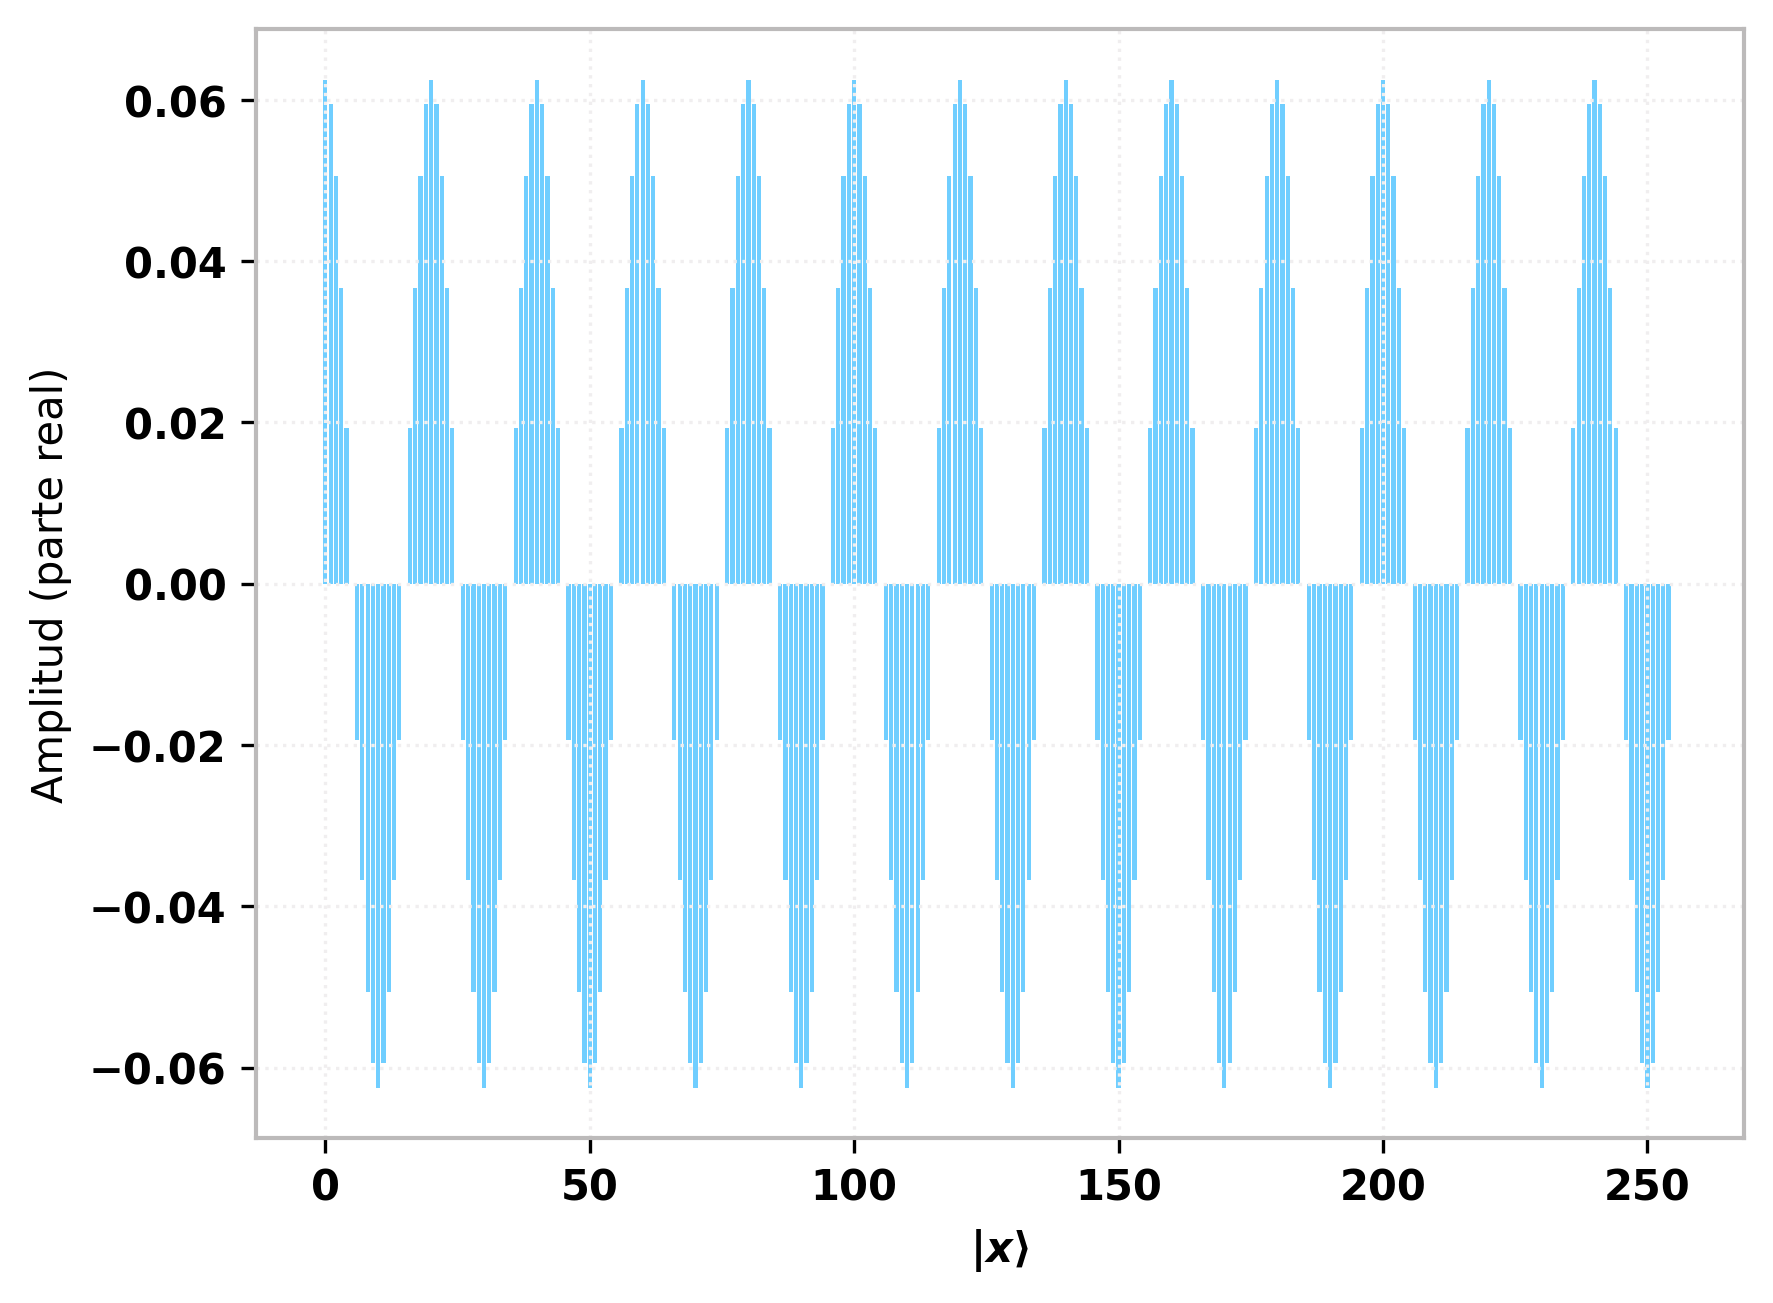

In [276]:
# Se crea un dispositivo cuántico simulado usando el simulador default.qubit de PennyLane
dev = qml.device("default.qubit")

# Convierte la función en un nodo cuántico (QNode) que se ejecutará en el dispositivo definido
@qml.qnode(dev)
def circuit(num_qubits):
  # Prepara el estado cuántico con periodo τ usando la función definida previamente
  preparar_estado(num_qubits)
  # Devuelve el vector de estado completo del sistema cuántico
  return qml.state()

# Ejecuta el circuito con NUM_QUBITS (5) y extrae la parte real del vector de estado
# Solo tomamos los primeros 2^NUM_QUBITS elementos que corresponden a los estados de los qubits principales
probs = circuit(NUM_QUBITS).real[:2**NUM_QUBITS]

# Crea un gráfico de barras donde el eje x representa cada estado base |x⟩ 
# y el eje y muestra la parte real de la amplitud para cada estado
plt.bar(range(len(probs)), probs)
# Etiqueta para el eje x usando notación LaTeX
plt.xlabel("$|x⟩$")
# Etiqueta para el eje y indicando que se muestra la parte real de la amplitud
plt.ylabel("Amplitud (parte real)")
# Muestra el gráfico
plt.show()


# Quantum Fourier Transform

La transformada de Fourier cuántica es la transformada discreta de Fourier clásica (DFT) aplicada a un vector de amplitudes de un estado cuántico.

La transformada de Fourier cuántica en $n$ qubits está definida como

$$\operatorname{QFT}: |x\rangle_n \mapsto \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \omega_N^{xk} |k\rangle$$

donde $\omega_N = e^{\frac{2 \pi i}{2^n}}$ es la $N$-ésima raíz de la unidad.

El circuito cuántico tiene la siguiente forma (sin aplicar las compuertas swap necesarias)

![circuito](https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Q_fourier_nqubits.png/960px-Q_fourier_nqubits.png "QFT circuit")

donde las compuertas de dos qubits usadas en el circuito

$$
H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$
y la versión controlada de la compuerta de fase
$$
R_k = \begin{pmatrix} 1 & 0 \\ 0 & e^{i2\pi/2^k}  \end{pmatrix}
$$
que pueden ser encontradas en Pennylane

## Implementación de la QFT

El objetivo es encontrar el valor de $\theta$ en el estado preparado en la sección anterior. Para esto

- Escriba la función cuántica `quantum_fourier_transform(num_qubits)` de manera que una vez se utilice en el circuito de la celda siguiente, se aplique la transformada de Fourier al estado de entrada.

- Encuentre el valor aproximado de $\tau$ a partir de las amplitudes del estado de salida.

- Muestre que añadir o remover qubits en el circuito incrementa la precisión de la aproximación de $\tau$.

In [277]:
def quantum_fourier_transform(num_qubits):
    """
    Transformada de Fourier Cuántica.
    
    Args:
        num_qubits (int): número de qubits.
    """
    # Iteramos a través de cada qubit
    for i in range(num_qubits):
        # Aplicamos la compuerta Hadamard al qubit i
        qml.Hadamard(wires=i)
        
        # Aplicamos las rotaciones controladas para cada qubit posterior
        for j in range(i + 1, num_qubits):
            # El ángulo de rotación depende de la distancia entre los qubits
            angle = 2 * np.pi / (2 ** (j - i + 1))
            # Aplicamos una rotación de fase controlada donde j es el control y i es el target
            qml.ControlledPhaseShift(angle, wires=[j, i])


# Visualizamos el circuito QFT usando la función de dibujo de PennyLane
#qml.draw_mpl(quantum_fourier_transform, decimals = 2)(NUM_QUBITS);

In [278]:
def swap_qubits(num_qubits):
  # Crea una lista con índices de todos los qubits (0 hasta num_qubits-1)
  wires = list(range(num_qubits))
  # Obtiene la primera mitad de los qubits (desde el índice 0 hasta la mitad)
  first_half_wires = wires[: num_qubits // 2]
  # Obtiene la segunda mitad de los qubits (desde la mitad hasta el final)
  last_half_wires = wires[-(num_qubits // 2) :]

  # Recorre los pares de qubits: uno de la primera mitad y otro de la segunda mitad (en orden inverso)
  # Esto intercambia los qubits simétricamente: el primero con el último, el segundo con el penúltimo, etc.
  for wire1, wire2 in zip(first_half_wires, reversed(last_half_wires)):
    # Aplica la compuerta SWAP que intercambia los estados cuánticos entre los dos qubits
    qml.SWAP(wires=[wire1, wire2])

In [279]:
@qml.qnode(dev)
def circuito(num_qubits):
  # Prepara el estado inicial con periodicidad τ definida por _rt
  preparar_estado(num_qubits)

  # Aplica la Transformada de Fourier Cuántica para extraer la información de frecuencia del estado
  # Esta transformación mapea la periodicidad en el dominio espacial a un pico en el dominio de frecuencia
  quantum_fourier_transform(num_qubits)

  # Intercambia los qubits para corregir el orden inverso que resulta de la QFT
  # La QFT produce resultados con bits invertidos, por lo que necesitamos esta operación
  swap_qubits(num_qubits)
  
  # Devuelve las probabilidades de medición de cada estado computacional
  # Esto nos permitirá identificar el valor de τ a partir del pico en la distribución
  return qml.probs(wires=range(0, num_qubits))

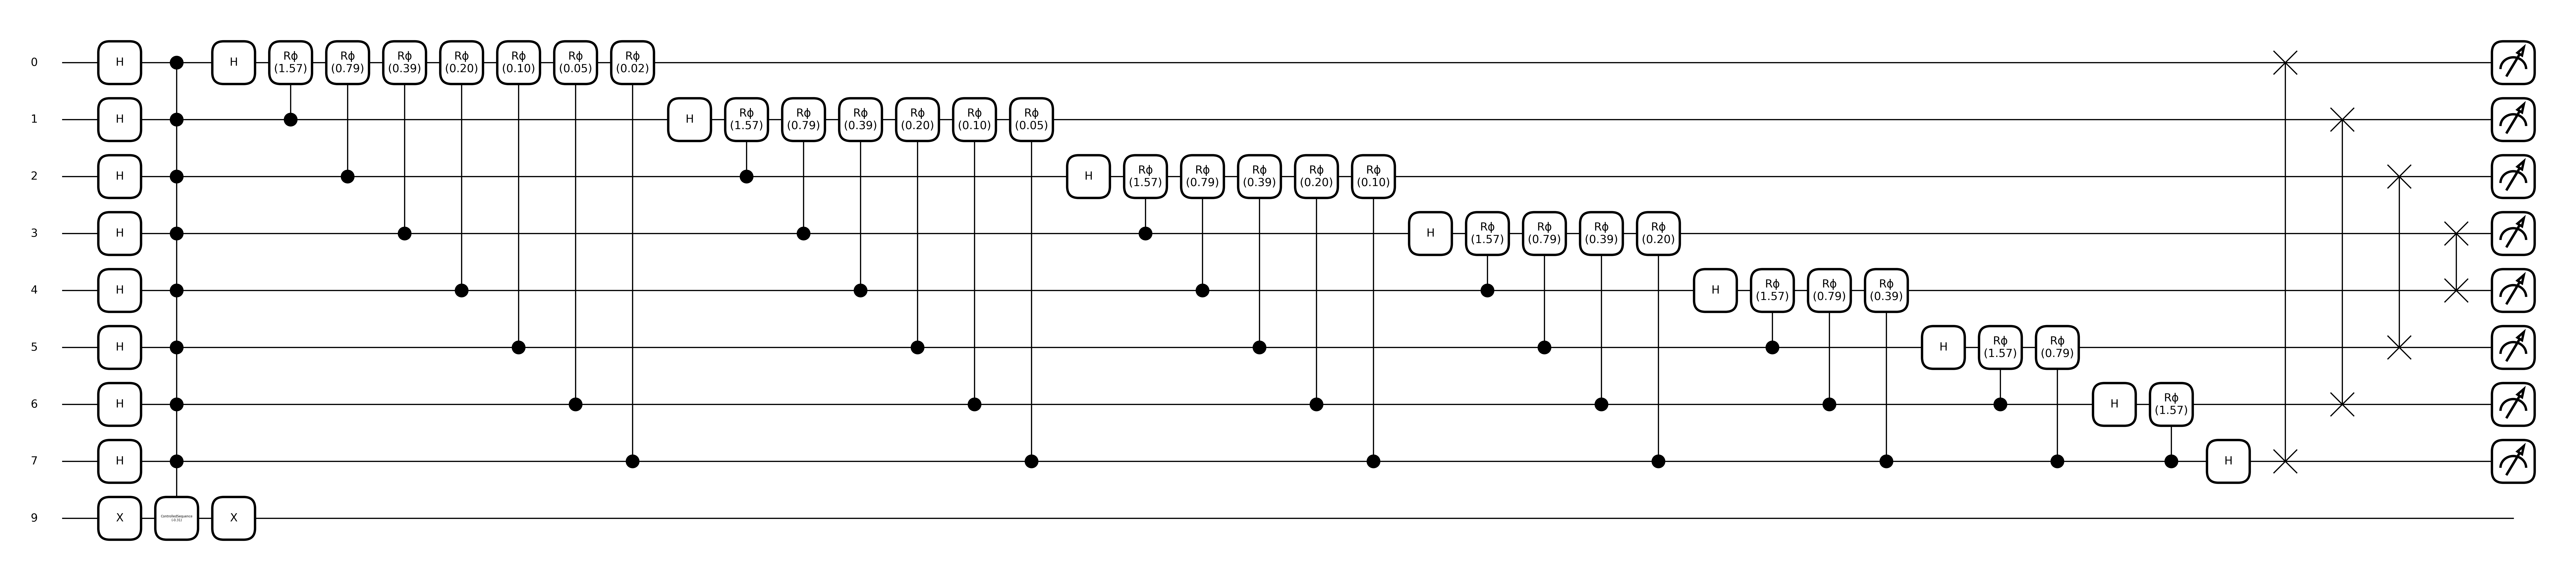

In [280]:
# Vamos a graficar el cicuito para visualizarlo
qml.draw_mpl(circuito, decimals = 2)(NUM_QUBITS);

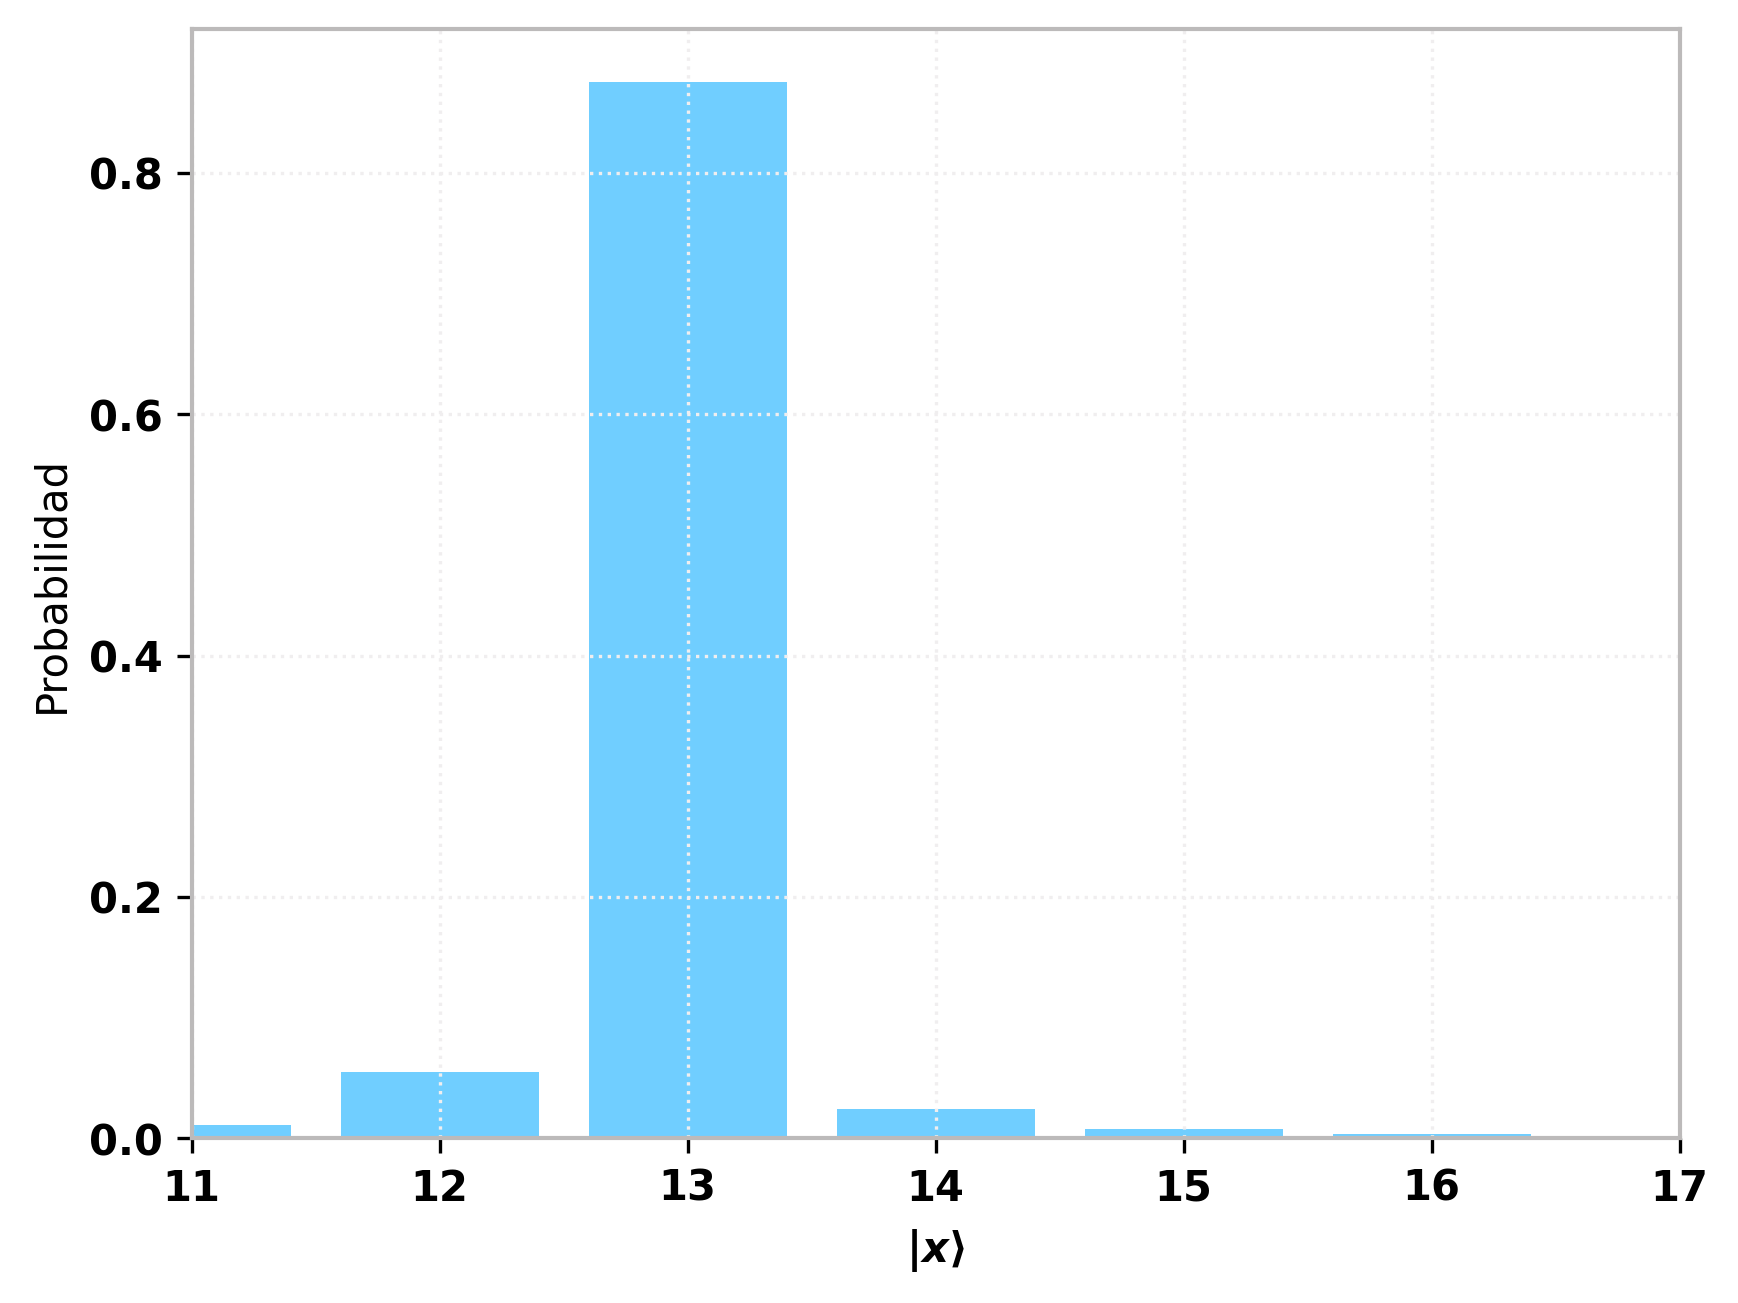

Pico máximo en el estado |13⟩
Valor aproximado de τ: 19.692307692307693


In [281]:
# Ejecuta el circuito con la transformada de Fourier cuántica y obtiene las probabilidades
# La QFT convierte la periodicidad en el dominio espacial a picos en el dominio de frecuencia
probs_qft = circuito(NUM_QUBITS).real[:2**NUM_QUBITS]

# Crea un gráfico de barras para visualizar las probabilidades resultantes después de aplicar la QFT
# El eje x representa los estados computacionales |x⟩ (de 0 a 2^NUM_QUBITS-1)
plt.bar(range(len(probs_qft)), probs_qft)

# Etiqueta el eje x usando notación LaTeX para representar los estados cuánticos
plt.xlabel("$|x⟩$")

# Etiqueta el eje y indicando que muestra las probabilidades después de la QFT
# La posición del pico más alto nos permitirá determinar el valor de τ
plt.ylabel("Probabilidad")



# Encuentra el índice donde ocurre la probabilidad máxima
# Este índice corresponderá aproximadamente a (2^NUM_QUBITS * k/τ) para algún k
max_idx = np.argmax(probs_qft)

# Calcular el valor aproximado de τ basado en la posición del pico
# Si el pico está en la posición j, entonces τ ≈ 2^n/j para k=1
tau_approx = 2**NUM_QUBITS / max_idx
# Vamos a definir los limites del eje x para que se vea bien el gráfico
plt.xlim(max_idx - 2**(NUM_QUBITS/divisor -1), max_idx + 2**(NUM_QUBITS/divisor))

# Muestra el gráfico con la distribución de probabilidades
plt.show()
print(f"Pico máximo en el estado |{max_idx}⟩")
print(f"Valor aproximado de τ: {tau_approx}")

Su resultado debe ser aproximadamente similar a

In [282]:
print(f"τ = {_rt}")

τ = 20


---

La siguiente función implementa la QFT usando Pennylane.
Puede usar su resultado para comparar.

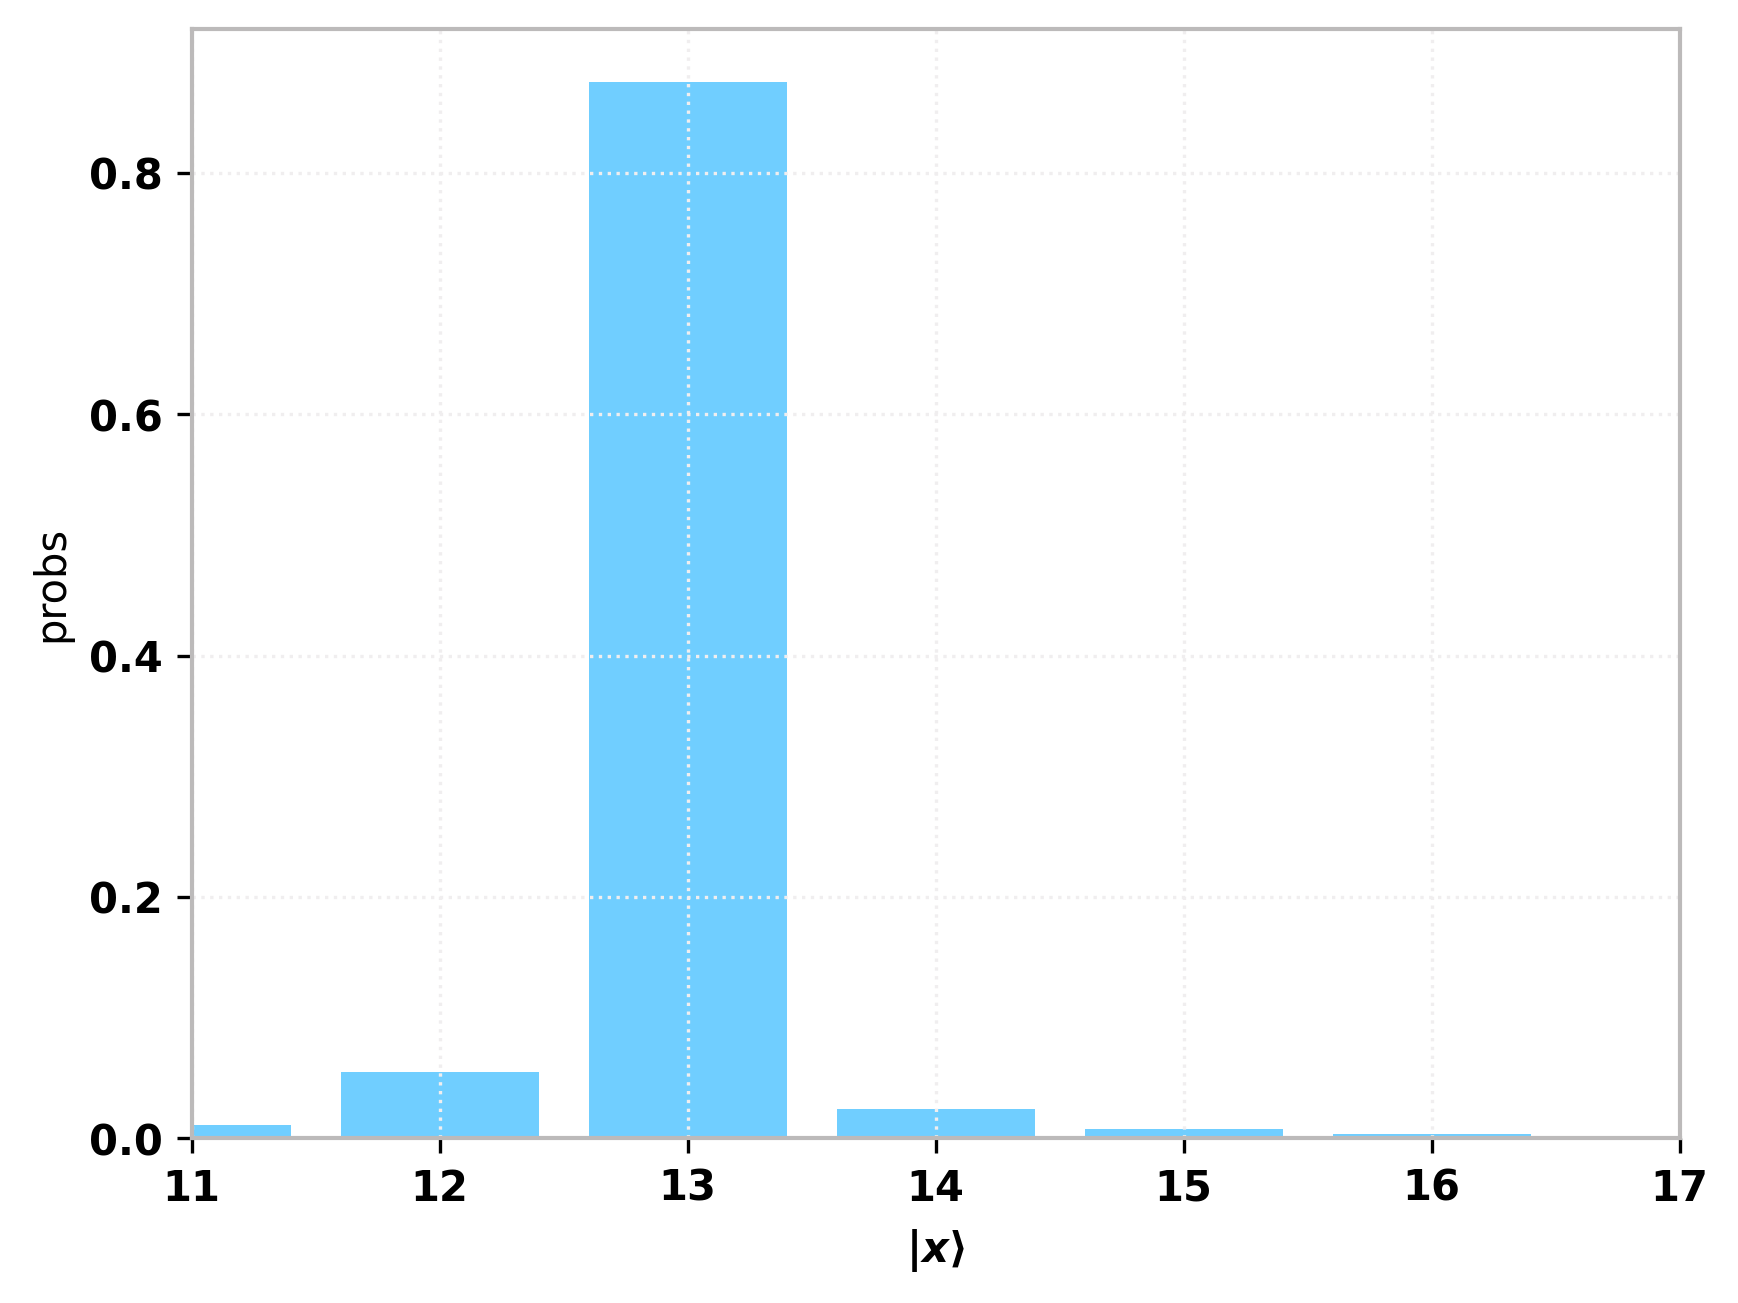

In [283]:
@qml.qnode(dev)
def circuito_pennylane(num_qubits):
  preparar_estado(num_qubits)
  qml.QFT(wires=range(0, num_qubits))
  return qml.probs(wires=range(0, num_qubits))

probs_pennylane = circuito_pennylane(NUM_QUBITS)

plt.bar(range(len(probs_pennylane)), probs_pennylane)
plt.xlabel("$|x⟩$")
# Vamos a definir los limites del eje x para que se vea bien el gráfico
plt.xlim(max_idx - 2**(NUM_QUBITS/divisor -1), max_idx + 2**(NUM_QUBITS/divisor))
plt.ylabel("probs")
plt.show()

In [284]:
# vamos a graifcar como evolucina el valor de la aproximacion de tau y el error conrespecto al valor real, variando el parametro del numero de qbits
# desde 1 hasta 10
t_ap_list = []
error_list = []
for i in range(1, 20):
    t_ap = (2**(i))/np.argmax(circuito(i).real[:2**i])
    error = abs(t_ap - _rt)/_rt
    t_ap_list.append(t_ap)
    error_list.append(error)

/tmp/ipykernel_136325/3399038307.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  t_ap = (2**(i))/np.argmax(circuito(i).real[:2**i])


/home/juan/Workspace/Base/Python/CompCuantica/venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3828: RuntimeWarning: invalid value encountered in scalar add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


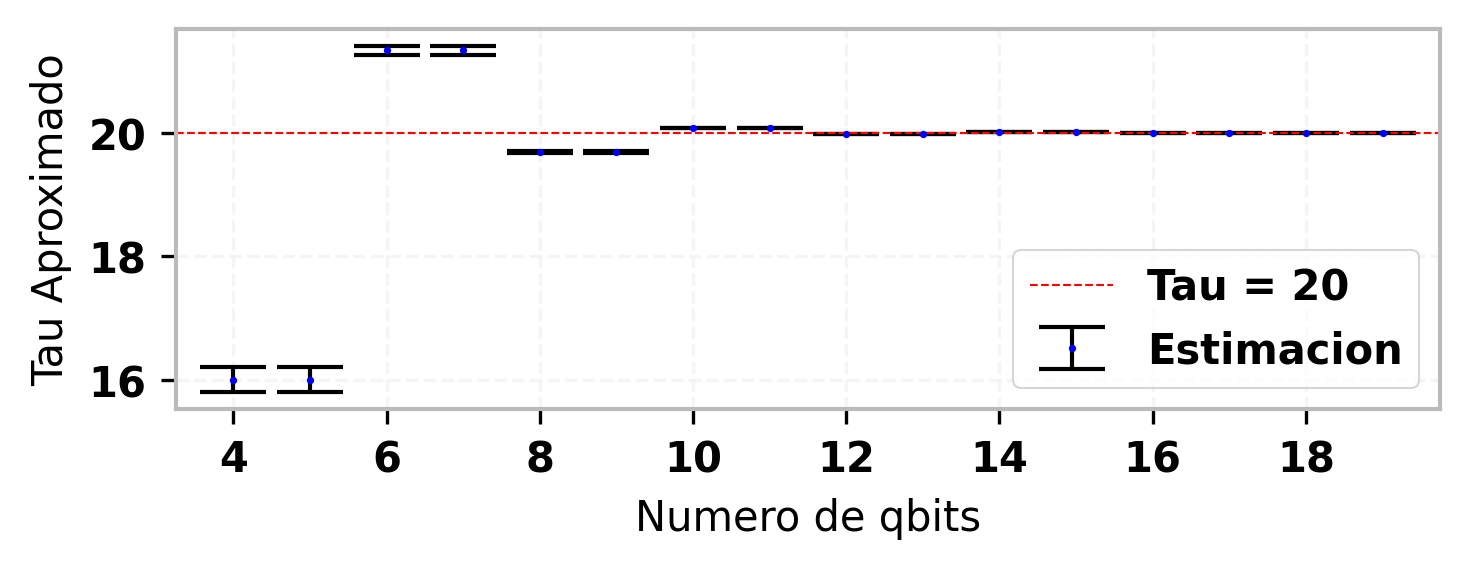

In [285]:
plt.figure(figsize=(5, 2))

# Gráfico con barras de error
plt.errorbar(
    range(1, 20),
    t_ap_list,
    yerr=error_list,
    fmt='.',               
    color='blue',          
    ecolor='black',       
    elinewidth=1,          
    capsize=8,            
    markersize=1.5,          
    label = 'Estimacion'
)

# Línea de referencia horizontal
plt.axhline(_rt, color='red', linestyle='--', linewidth= 0.5, label=f"Tau = {_rt}")

# Detalles extra
plt.xlabel("Numero de qbits", fontsize=10)
plt.ylabel("Tau Aproximado", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()


plt.show()